## Characterization of the flow 

In [85]:
# load appropriate modules
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from scipy import linalg as lin
from scipy import signal as sig
from scipy import fftpack as fft
from scipy import interpolate as naiso
from matplotlib import colors, ticker, cm
import xrft
#import gsw

In [86]:
from xgcm import Grid

In [87]:
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')
    return kr, iso_f

In [88]:
plt.rcParams.update({'font.size': 12})

In [89]:
dir_zarr = '/swot/SUM04/dbalwada/channel_model/05km_sponge/run_tracers_restored_3day_output/run_tracers_restored_zarr/'
ds_model = xr.open_zarr(dir_zarr)

In [90]:
grid = Grid(ds_model, periodic='X')

In [91]:
(ds_model.time[2]- ds_model.time[1]).values/1e9/24/3600

numpy.timedelta64(3,'ns')

#### Check how Parseval's is being satisfied 

In [215]:
da = xr.DataArray(np.random.rand(1000),
                  dims=['x'],
                  coords={'x': np.arange(1000)})

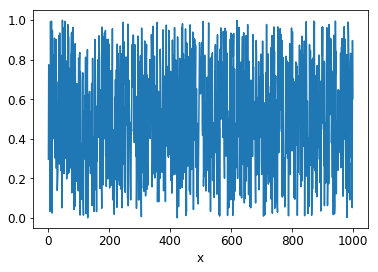

In [219]:
da.plot()

In [221]:
(da**2).mean()

<xarray.DataArray ()>
array(0.33032093)

In [216]:
da_ps = xrft.power_spectrum(da)

In [222]:
da_ps.sum('freq_x')*da_ps.freq_x_spacing

<xarray.DataArray ()>
array(0.33032093)
Coordinates:
    freq_x_spacing  float64 0.001

\begin{equation}
\overline{\theta^2(x)} = \sum |\hat{\theta(k)}|^2  dk
\end{equation}

In [92]:
def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
        
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [93]:
220*3

660

In [94]:
def iso_spec_single(ds): 
    klen = len(ds.freq_XC)
    nfactor = 4. 
    ds_iso = np.zeros([int(klen/nfactor+1)])
    
    kr, ds_iso = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds, 
                            len(ds.freq_XC), nfactor)
    
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'kr':kr }, 
                             dims=['kr'])
    
    return ds_iso_xr

In [95]:
def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
        
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

#### Characterize EKE, Tempflux, Tracerflux

In [96]:
U = grid.interp(ds_model.U - ds_model.U.mean('time'), 'X')
V = grid.interp(ds_model.V - ds_model.V.mean('time'), 'Y', boundary='extend')
T = ds_model.T - ds_model.T.mean('time')

Cy1 = ds_model.PTRACER01 - ds_model.PTRACER01.mean('time')
Cz1 = ds_model.PTRACER03 - ds_model.PTRACER03.mean('time')
Cx1 = ds_model.PTRACER05 - ds_model.PTRACER05.mean('time')

Cy2 = ds_model.PTRACER02 - ds_model.PTRACER02.mean('time')
Cz2 = ds_model.PTRACER04 - ds_model.PTRACER04.mean('time')
Cx2 = ds_model.PTRACER06 - ds_model.PTRACER06.mean('time')

#### Upstream 
Choose just one depth for now (500m)

In [97]:
Xsel = slice(0,900e3)
Ysel = slice(550e3, 1450e3)

EKE 

In [98]:
UPowSpec_klw = xrft.power_spectrum(U.sel(XC=Xsel, YC=Ysel).sel(Z=-500, method='nearest').chunk({'time':330}), dim=['XC','YC','time'],
                                  chunks_to_segments=True, window='True')
VPowSpec_klw = xrft.power_spectrum(V.sel(XC=Xsel, YC=Ysel).sel(Z=-500, method='nearest').chunk({'time':330}), dim=['XC','YC','time'],
                                  chunks_to_segments=True, window='True')

In [99]:
UPowSpec_klw = UPowSpec_klw.mean(['time_segment', 'XC_segment','YC_segment'])
VPowSpec_klw = VPowSpec_klw.mean(['time_segment', 'XC_segment','YC_segment'])

In [100]:
EKE_klw = 0.5*(UPowSpec_klw + VPowSpec_klw) 

In [101]:
EKE_klw.load()

<xarray.DataArray (freq_time: 330, freq_YC: 180, freq_XC: 180)>
array([[[0.00534105, 0.02947935, 0.07163777, ..., 0.15701275,
         0.07163777, 0.02947935],
        [0.05086338, 0.0462527 , 0.06625204, ..., 0.10539663,
         0.0796408 , 0.06111494],
        [0.20839964, 0.147343  , 0.17203529, ..., 0.17211671,
         0.09014822, 0.12294974],
        ...,
        [0.36525443, 0.25706734, 0.20725645, ..., 0.39549611,
         0.32845601, 0.28440664],
        [0.20839964, 0.12294974, 0.09014822, ..., 0.2846224 ,
         0.17203529, 0.147343  ],
        [0.05086338, 0.06111494, 0.0796408 , ..., 0.20486485,
         0.06625204, 0.0462527 ]],

       [[0.01219924, 0.03153696, 0.10079741, ..., 0.12389166,
         0.06739978, 0.01654588],
        [0.06022869, 0.05892787, 0.09902095, ..., 0.075684  ,
         0.07328182, 0.06236559],
        [0.23374768, 0.16646816, 0.18425262, ..., 0.22875262,
         0.12727034, 0.17366205],
        ...,
        [0.32138365, 0.23943158, 0.17581853,

In [102]:
EKE_Kw = iso_spec(EKE_klw)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


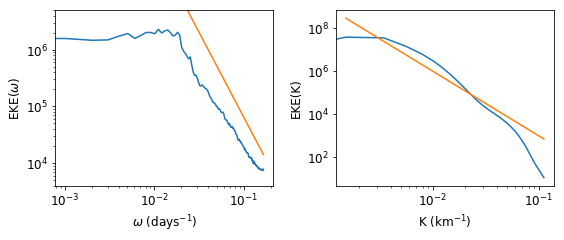

In [103]:
plt.figure(figsize=(8,3.5))
plt.subplot(121)
plt.plot(EKE_Kw.freq_time*24*3600, EKE_Kw.sum('kr'))
plt.plot(EKE_Kw.freq_time*24*3600, 1e-13*EKE_Kw.freq_time**-3)
plt.ylim([4e3, 5e6])
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'EKE($\omega$)')
plt.xlabel(r'$\omega$ (days$^{-1}$)')

plt.subplot(122)
plt.plot(EKE_Kw.kr*1e3, EKE_Kw.sum('freq_time'))
plt.plot(EKE_Kw.kr*1e3, 1e-9*EKE_Kw.kr**-3)
plt.xscale('log')
plt.yscale('log')
plt.ylabel(r'EKE(K)')
plt.xlabel(r'K (km$^{-1}$)')
plt.tight_layout()

In [104]:
import matplotlib.colors as colors

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1560: RuntimeWarning: invalid value encountered in less_equal
  z = ma.masked_where(z <= 0, z)
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/matplotlib/contour.py:1561: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


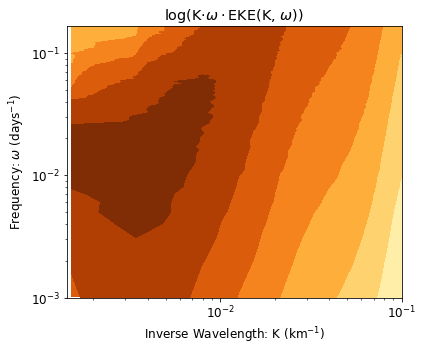

In [105]:
plt.figure(figsize=(6,5))

plt.contourf(EKE_Kw.kr*1e3, EKE_Kw.freq_time*24*3600, EKE_Kw*EKE_Kw.kr*EKE_Kw.freq_time, 
            norm=colors.LogNorm(), cmap='YlOrBr')
plt.xscale('log')
plt.yscale('log')

plt.xlim([1/700, 1/10])
plt.ylim([1/1000, 1/6])

plt.ylabel(r'Frequency: $\omega$ (days$^{-1}$)')
plt.xlabel(r'Inverse Wavelength: K (km$^{-1}$)')

plt.title(r'log(K$\cdot \omega\cdot$EKE(K, $\omega$))')

#plt.colorbar()
plt.savefig('omega_k_spectra.eps')

Time Scales

In [392]:
1980/12

165.0

In [8]:
UPowSpec_w = xrft.power_spectrum(U.chunk({'time':1980}), dim=['time'],
                                  chunks_to_segments=True, window='True')
VPowSpec_w = xrft.power_spectrum(V.chunk({'time':1980}), dim=['time'],
                                  chunks_to_segments=True, window='True')

In [9]:
UPowSpec_w = UPowSpec_w.mean('time_segment')
VPowSpec_w = VPowSpec_w.mean('time_segment')

In [10]:
freq_max_U = UPowSpec_w.freq_time.where(UPowSpec_w*UPowSpec_w.freq_time == (UPowSpec_w*UPowSpec_w.freq_time).max('freq_time')).mean('freq_time')
freq_max_V = VPowSpec_w.freq_time.where(VPowSpec_w*VPowSpec_w.freq_time == (VPowSpec_w*VPowSpec_w.freq_time).max('freq_time')).mean('freq_time')

In [11]:
Tscale_U = 1/freq_max_U/24/3600
Tscale_V = 1/freq_max_V/24/3600

In [12]:
Tscale_U.load()
Tscale_V.load()

<xarray.DataArray 'freq_time' (Z: 40, YC: 400, XC: 400)>
array([[[-1.18800000e+04, -1.18800000e+04, -1.18800000e+04, ...,
         -1.18800000e+04, -1.18800000e+04, -1.18800000e+04],
        [ 6.11111111e+00,  6.46354733e+00,  6.51315789e+00, ...,
          6.50602410e+00,  6.50602410e+00,  6.11111111e+00],
        [ 6.11111111e+00,  6.04887984e+00,  8.02702703e+00, ...,
          6.51315789e+00,  6.50602410e+00,  9.15254237e+00],
        ...,
        [ 9.38388626e+00,  2.80188679e+01,  2.80188679e+01, ...,
          2.78873239e+01,  1.92233010e+01,  8.30769231e+00],
        [ 9.38388626e+00,  9.38388626e+00,  2.80188679e+01, ...,
          3.90789474e+01,  3.90789474e+01,  8.30769231e+00],
        [ 6.13003096e+00,  8.44950213e+00,  8.44950213e+00, ...,
          4.82926829e+01,  4.82926829e+01,  6.16822430e+00]],

       [[-1.18800000e+04, -1.18800000e+04, -1.18800000e+04, ...,
         -1.18800000e+04, -1.18800000e+04, -1.18800000e+04],
        [ 6.11111111e+00,  6.46354733e+00,  6.

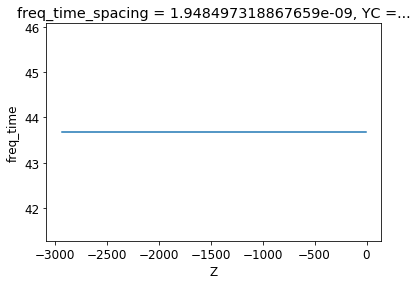

In [13]:
Tscale_U.sel(XC=0, YC=1000e3, method='nearest').plot()

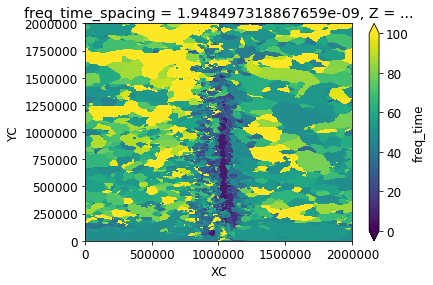

In [20]:
Tscale_U.sel( Z=-1000, method='nearest').plot(vmin=0, vmax=100)

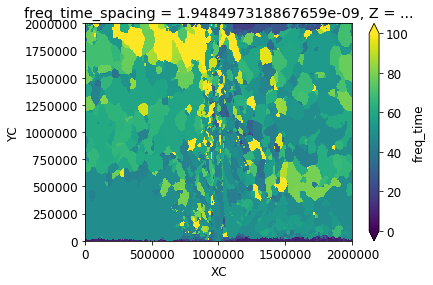

In [21]:
Tscale_V.sel( Z=-1000, method='nearest').plot(vmin=0, vmax=100)

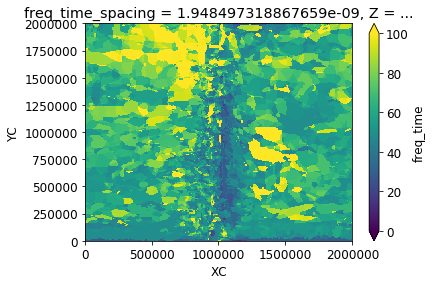

In [23]:
(0.5*(Tscale_U + Tscale_V)).sel( Z=-1000, method='nearest').plot(vmin=0, vmax=100)

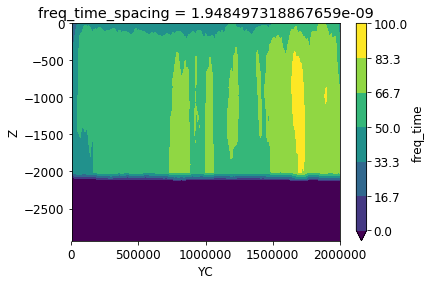

In [25]:
(0.5*(Tscale_U + Tscale_V)).mean('XC').plot.contourf(vmin=0, vmax=100)

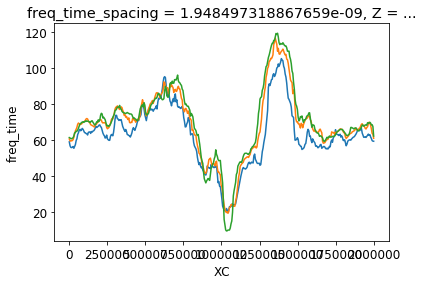

In [18]:
Tscale_U.sel(YC=slice(600e3,1400e3)).sel(Z=-400, method='nearest').mean('YC').plot()
Tscale_U.sel(YC=slice(600e3,1400e3)).sel(Z=-800, method='nearest').mean('YC').plot()
Tscale_U.sel(YC=slice(600e3,1400e3)).sel(Z=-1500, method='nearest').mean('YC').plot()


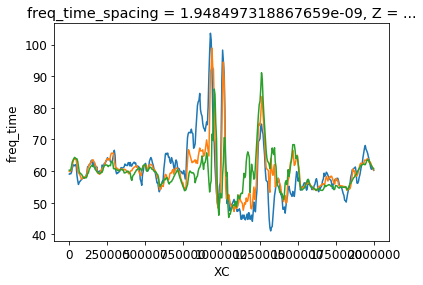

In [19]:
Tscale_V.sel(YC=slice(600e3,1400e3)).sel(Z=-400, method='nearest').mean('YC').plot()
Tscale_V.sel(YC=slice(600e3,1400e3)).sel(Z=-800, method='nearest').mean('YC').plot()
Tscale_V.sel(YC=slice(600e3,1400e3)).sel(Z=-1500, method='nearest').mean('YC').plot()

In [27]:
mixing_times = xr.merge([Tscale_U.rename('Tu'), Tscale_V.rename('Tv')])

In [28]:
mixing_times.to_netcdf('mixing_times.nc')

#### Wave speed

In [76]:
X = ds_model.XC
T = ds_model.time.isel(time=slice(0,200))

In [77]:
temp = ds_model.Eta.sel(YC=1000e3, method='nearest').isel(time=slice(0,200)).load()

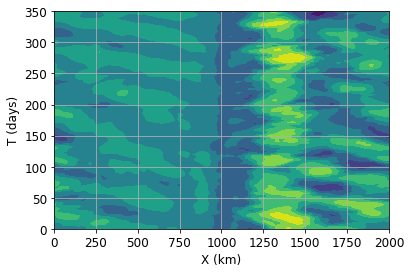

In [82]:
plt.contourf(X/1e3, (T-T[0])/24/3600/1e9, temp)
plt.xlabel('X (km)')
plt.ylabel('T (days)')
plt.ylim([0,350])
plt.grid()

In [83]:
750000/50/24/3600

0.1736111111111111

TypeError: invalid type promotion

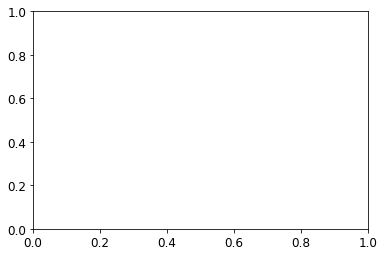

In [34]:
ds_model.Eta.sel(YC=1000e3, method='nearest').isel(time=slice(-100, -1)).plot()

#### Horizontal Temperature Flux

In [296]:
VT = (V.sel(XC=Xsel, YC=Ysel)*T.sel(XC=Xsel, YC=Ysel)).mean(['XC','YC','time'])

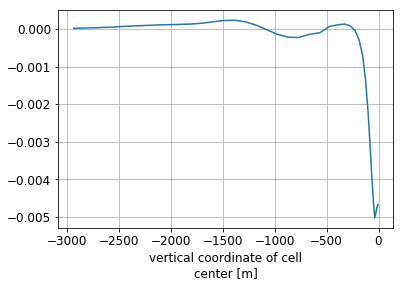

In [299]:
(VT.T).plot()
plt.grid()

In [323]:
VTCrossSpec_klw = xrft.cross_spectrum(V.sel(XC=Xsel, YC=Ysel).sel(Z=-500, method='nearest').chunk({'time':330}), 
                                      T.sel(XC=Xsel, YC=Ysel).sel(Z=-500, method='nearest').chunk({'time':330}),
                                      dim=['XC','YC','time'],
                                      chunks_to_segments=True, window='True')

In [324]:
VTCrossSpec_klw = VTCrossSpec_klw.mean(['time_segment', 'XC_segment','YC_segment'])

In [325]:
VTCrossSpec_klw.load()

<xarray.DataArray (freq_time: 330, freq_YC: 180, freq_XC: 180)>
array([[[-1.8047352 , -1.47718391, -0.76902868, ..., -0.38738062,
         -0.76902868, -1.47718391],
        [-3.48071335, -1.44507983, -0.58574279, ...,  0.56838674,
         -2.08654158, -3.31067494],
        [-2.36930987, -1.50080896, -2.16340778, ...,  2.03181697,
          0.80184821, -1.43679587],
        ...,
        [-1.53246027,  1.44661543,  6.15173504, ..., -1.21465428,
         -3.07257399, -0.51645816],
        [-2.36930987, -1.43679587,  0.80184821, ...,  0.57931738,
         -2.16340778, -1.50080896],
        [-3.48071335, -3.31067494, -2.08654158, ..., -0.61208117,
         -0.58574279, -1.44507983]],

       [[-1.23692604, -0.74610298, -0.43079438, ...,  0.26122105,
         -1.27179099, -1.37295987],
        [-0.36602106, -2.22297591, -2.01404297, ...,  0.05964882,
         -0.60828045, -1.07823365],
        [-0.82667916, -3.16746374, -4.94183778, ..., -0.17482666,
          0.55285121,  0.51796719],
   

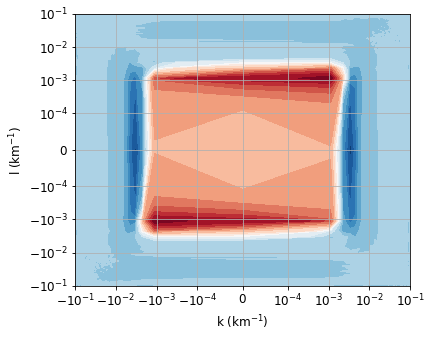

In [335]:
plt.figure(figsize=(6,5))
plt.contourf(VTCrossSpec_klw.freq_XC*1e3, VTCrossSpec_klw.freq_YC*1e3, VTCrossSpec_klw.sum('freq_time'), cmap='RdBu_r', levels=21)
plt.xscale('symlog', linthreshx=1e-4)
plt.yscale('symlog', linthreshy=1e-4)

plt.xlabel('k (km$^{-1}$)')
plt.ylabel('l (km$^{-1}$)')
plt.grid()

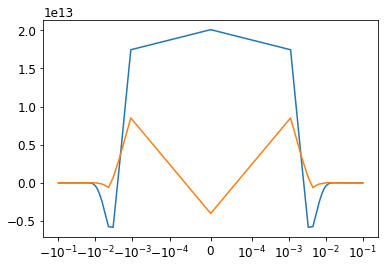

In [334]:
plt.plot(VTCrossSpec_klw.freq_XC*1e3, VTCrossSpec_klw.sum(['freq_time', 'freq_YC']))
plt.plot(VTCrossSpec_klw.freq_XC*1e3, VTCrossSpec_klw.sum(['freq_time', 'freq_XC']))
plt.xscale('symlog', linthreshx=1e-4)


In [305]:
VTCrossSpec_Kw = iso_spec(VTCrossSpec_klw)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [306]:
VTCrossSpec_Kw.mean(['kr','freq_time'])

<xarray.DataArray ()>
array(-66.64971911)

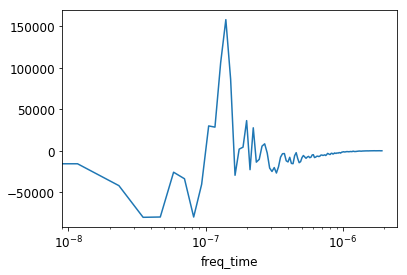

In [321]:
VTCrossSpec_Kw.sum('kr').plot()
plt.xscale('log')

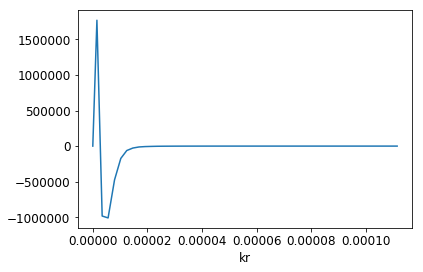

In [309]:
VTCrossSpec_Kw.sum('freq_time').plot()

<xarray.DataArray (Z: 40)>
dask.array<mean_agg-aggregate, shape=(40,), dtype=float32, chunksize=(1,)>
Coordinates:
  * Z        (Z) float32 -5.0 -15.0 -25.0 -36.0 ... -2727.5 -2830.5 -2933.5
    PHrefC   (Z) float32 49.05 147.15 245.25 ... 26756.775 27767.205 28777.635
    drF      (Z) float32 10.0 10.0 10.0 12.0 14.0 ... 103.0 103.0 103.0 103.0

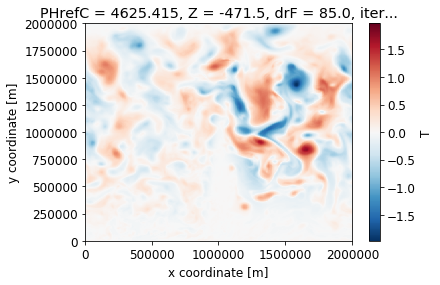

In [337]:
T.isel(time=-1).sel(Z=-500, method='nearest').plot()

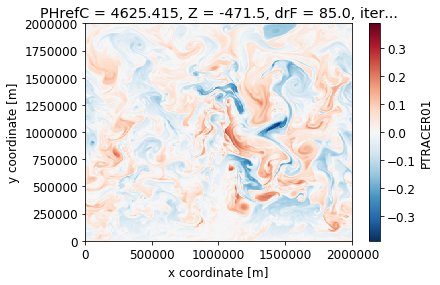

In [353]:
Cy1.isel(time=-1).sel(Z=-500, method='nearest').plot()

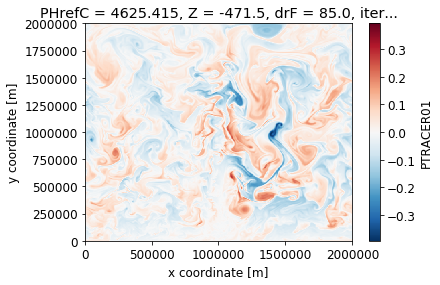

In [355]:
Cy1.isel(time=-2).sel(Z=-500, method='nearest').plot()

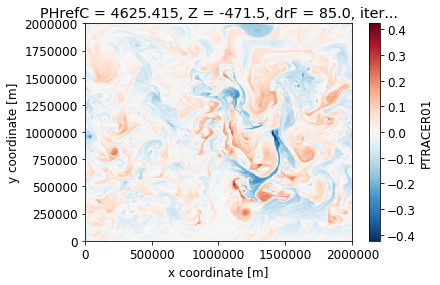

In [356]:
Cy1.isel(time=-3).sel(Z=-500, method='nearest').plot()

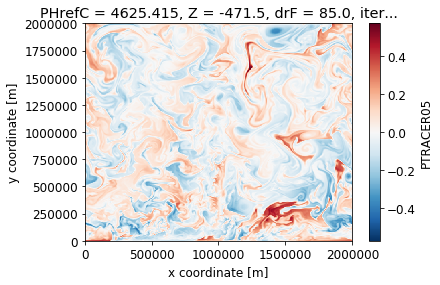

In [352]:
Cx1.isel(time=-1).sel(Z=-500, method='nearest').plot()

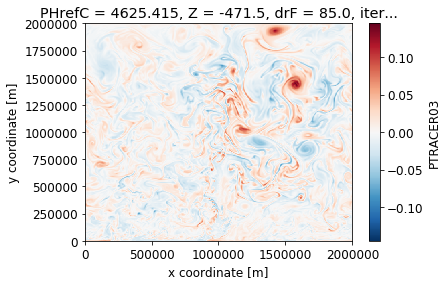

In [354]:
Cz1.isel(time=-1).sel(Z=-500, method='nearest').plot()

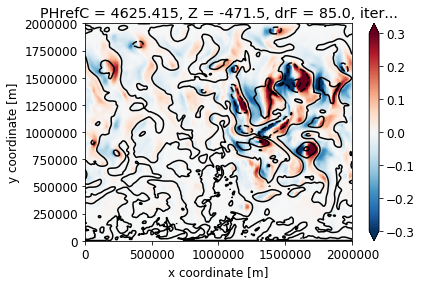

In [348]:
(V*T).isel(time=-1).sel(Z=-500, method='nearest').plot(vmin=-0.3)
T.isel(time=-1).sel(Z=-500, method='nearest').plot.contour(colors='k')

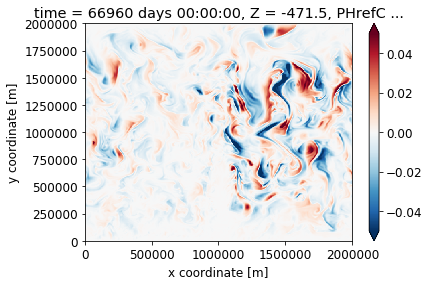

In [344]:
(V*Cy1).isel(time=-1).sel(Z=-500, method='nearest').plot(vmin=-0.05)

In [64]:
V = grid.interp(ds_model.V - ds_model.V.mean('time'),'Y', boundary='extend')
U = grid.interp(ds_model.U - ds_model.U.mean('time'),'X')
T = ds_model.T - ds_model.T.mean('time')
C = ds_model.PTRACER01 - ds_model.PTRACER01.mean('time')

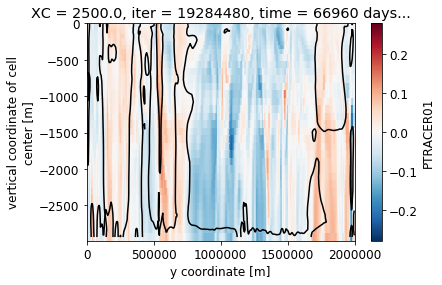

In [65]:
C.isel(time=-1).sel(XC=0, method='nearest').plot()
T.isel(time=-1).sel(XC=0, method='nearest').plot.contour(levels=np.linspace(0,8,9), colors='k')

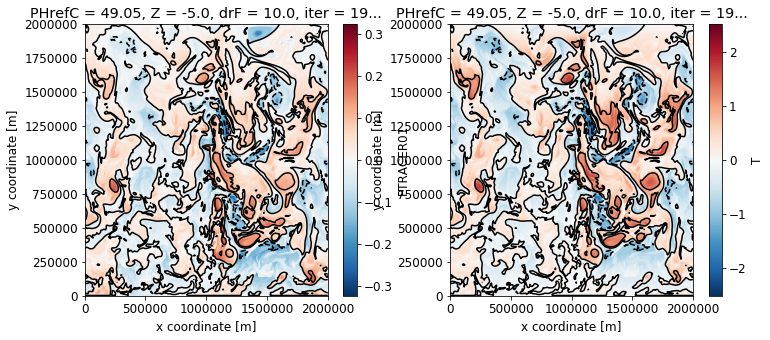

In [66]:
plt.figure(figsize=(12,5 ))
plt.subplot(121)
C.isel(time=-1).sel(Z=0, method='nearest').plot()
T.isel(time=-1).sel(Z=0, method='nearest').plot.contour(colors='k')

plt.subplot(122)
T.isel(time=-1).sel(Z=0, method='nearest').plot()
T.isel(time=-1).sel(Z=0, method='nearest').plot.contour(colors='k')

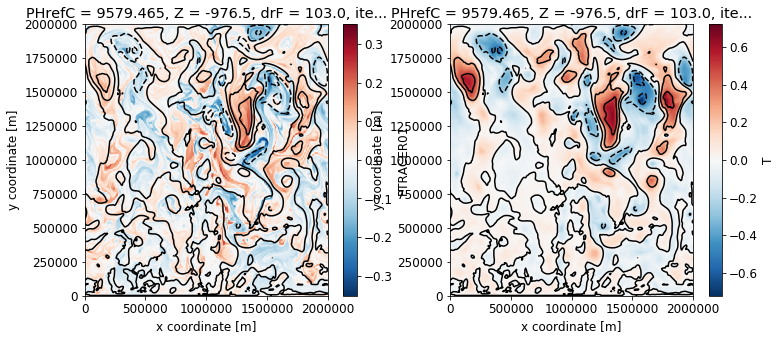

In [67]:
plt.figure(figsize=(12,5 ))
plt.subplot(121)
C.isel(time=-1).sel(Z=-1000, method='nearest').plot()
T.isel(time=-1).sel(Z=-1000, method='nearest').plot.contour(colors='k')

plt.subplot(122)
T.isel(time=-1).sel(Z=-1000, method='nearest').plot()
T.isel(time=-1).sel(Z=-1000, method='nearest').plot.contour(colors='k')

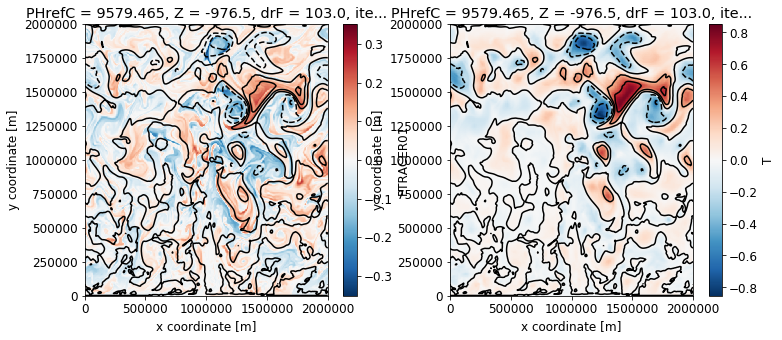

In [350]:
plt.figure(figsize=(12,5 ))
plt.subplot(121)
C.isel(time=-10).sel(Z=-1000, method='nearest').plot()
T.isel(time=-10).sel(Z=-1000, method='nearest').plot.contour(colors='k')

plt.subplot(122)
T.isel(time=-10).sel(Z=-1000, method='nearest').plot()
T.isel(time=-10).sel(Z=-1000, method='nearest').plot.contour(colors='k')

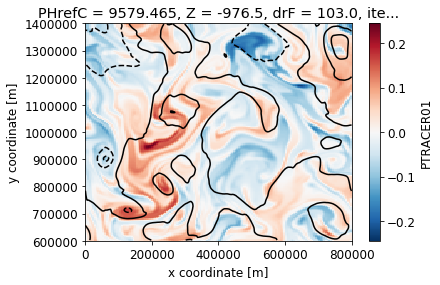

In [69]:
C.isel(time=-1).sel(Z=-1000, method='nearest').sel(XC=slice(0,800e3), YC=slice(600e3,1400e3)).plot()
T.isel(time=-1).sel(Z=-1000, method='nearest').sel(XC=slice(0,800e3), YC=slice(600e3,1400e3)).plot.contour(colors='k')

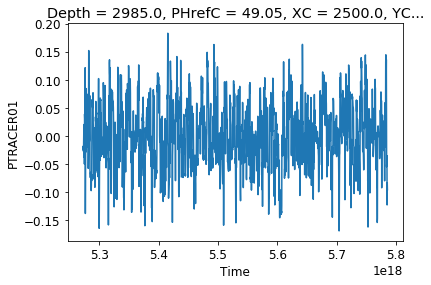

In [70]:
C.sel(XC=0, YC=1000e3, Z=1000, method='nearest').plot()

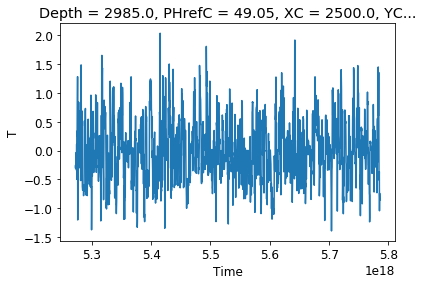

In [71]:
T.sel(XC=0, YC=1000e3, Z=1000, method='nearest').plot()

In [72]:
Tregion = T.sel(Z=-1000, method='nearest').sel(XC=slice(0,800e3), YC=slice(600e3,1400e3)).chunk({'time':1980})
Cregion = C.sel(Z=-1000, method='nearest').sel(XC=slice(0,800e3), YC=slice(600e3,1400e3)).chunk({'time':1980})
Vregion = V.sel(Z=-1000, method='nearest').sel(XC=slice(0,800e3), YC=slice(600e3,1400e3)).chunk({'time':1980})
Uregion = U.sel(Z=-1000, method='nearest').sel(XC=slice(0,800e3), YC=slice(600e3,1400e3)).chunk({'time':1980})

In [73]:
Tps_region  = xrft.power_spectrum(Tregion, dim=['time'], window='hanning', detrend='linear').rename('T_spec').load()
Cps_region  = xrft.power_spectrum(Cregion, dim=['time'], window='hanning', detrend='linear').rename('C_spec').load()
Vps_region  = xrft.power_spectrum(Vregion, dim=['time'], window='hanning', detrend='linear').rename('V_spec').load()

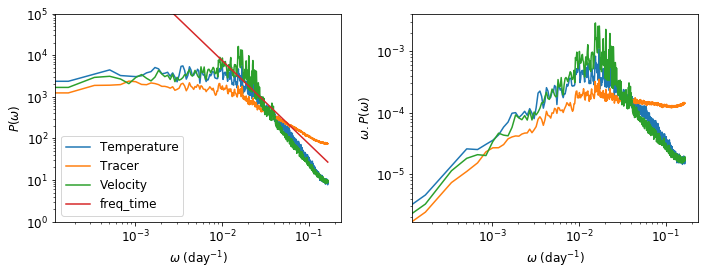

In [74]:
plt.figure(figsize=(10,4))

plt.subplot(121)
plt.plot(Tps_region.freq_time*24*3600, Tps_region.mean(['XC','YC']), label='Temperature')
plt.plot(Tps_region.freq_time*24*3600, Cps_region.mean(['XC','YC']), label='Tracer')
plt.plot(Tps_region.freq_time*24*3600, Vps_region.mean(['XC','YC']), label='Velocity')

plt.plot(Tps_region.freq_time*24*3600, 1e-10*Tps_region.freq_time**-2)

plt.xscale('log')
plt.yscale('log')
plt.ylim([1, 1e5])
plt.xlabel(r'$\omega$ (day$^{-1}$)')
plt.ylabel(r'$P (\omega)$')
plt.legend()

plt.subplot(122)
plt.plot(Tps_region.freq_time*24*3600, Tps_region.freq_time*Tps_region.mean(['XC','YC']), label='Temperature')
plt.plot(Tps_region.freq_time*24*3600, Tps_region.freq_time*Cps_region.mean(['XC','YC']), label='Tracer')
plt.plot(Tps_region.freq_time*24*3600, Tps_region.freq_time*Vps_region.mean(['XC','YC']), label='Velocity')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\omega$ (day$^{-1}$)')
plt.ylabel(r'$\omega.P (\omega)$')

plt.tight_layout()

In [75]:
Tps_region_k  = xrft.power_spectrum(Tregion.chunk({'time':1}), dim=['XC','YC'], window='hanning').rename('T_spec').load()
Cps_region_k  = xrft.power_spectrum(Cregion.chunk({'time':1}), dim=['XC','YC'], window='hanning').rename('C_spec').load()
Vps_region_k  = xrft.power_spectrum(Vregion.chunk({'time':1}), dim=['XC','YC'], window='hanning').rename('V_spec').load()
Ups_region_k  = xrft.power_spectrum(Uregion.chunk({'time':1}), dim=['XC','YC'], window='hanning').rename('V_spec').load()

In [76]:
VTps_region_k  = xrft.cross_spectrum(Tregion.chunk({'time':1}), Vregion.chunk({'time':1}),
                                     dim=['XC','YC'], window='hanning').rename('T_spec').load()

In [77]:
VCps_region_k  = xrft.cross_spectrum(Cregion.chunk({'time':1}), Vregion.chunk({'time':1}),
                                     dim=['XC','YC'], window='hanning').rename('T_spec').load()

In [78]:
def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
        
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'time':ds.time.values, 'kr':kr }, 
                             dims=['time','kr'])
    
    return ds_iso_xr

In [82]:
Tps_region_k

<xarray.DataArray (time: 1980, kr: 41)>
array([[           nan, 1.88026237e+01, 2.09047373e+01, ...,
        1.13526311e-05, 9.55969716e-06, 5.10186890e-06],
       [           nan, 1.96505410e+01, 2.03886110e+01, ...,
        1.14888074e-05, 1.26016942e-05, 7.06565327e-06],
       [           nan, 1.91658006e+01, 1.98947444e+01, ...,
        1.28745048e-05, 1.41503723e-05, 6.62770031e-06],
       ...,
       [           nan, 1.11614237e+01, 6.42314393e+00, ...,
        7.04342251e-06, 7.50874928e-06, 4.14939393e-06],
       [           nan, 1.18789930e+01, 7.65041943e+00, ...,
        8.99320850e-06, 9.33143336e-06, 4.73679638e-06],
       [           nan, 1.22322621e+01, 8.91903160e+00, ...,
        8.70449594e-06, 8.32757840e-06, 3.59299132e-06]])
Coordinates:
  * time     (time) timedelta64[ns] 61023 days 61026 days ... 66960 days
  * kr       (kr) float64 0.0 1.698e-06 3.866e-06 ... 9.743e-05 0.0001114

In [79]:
Tps_region_k = iso_spec(Tps_region_k)
Cps_region_k = iso_spec(Cps_region_k)
Vps_region_k = iso_spec(Vps_region_k)
Ups_region_k = iso_spec(Ups_region_k)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [80]:
VTps_region_k = iso_spec(VTps_region_k)
VCps_region_k = iso_spec(VCps_region_k)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


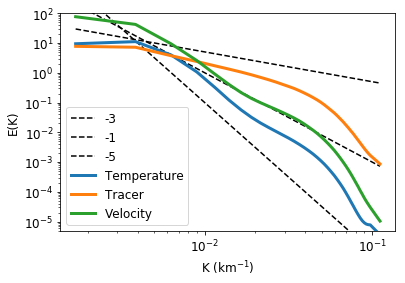

In [81]:

plt.plot(Tps_region_k.kr*1e3, 1e-15*Tps_region_k.kr**-3, linestyle='--', color='k', label='-3')
plt.plot(Tps_region_k.kr*1e3, 0.5e-4*Tps_region_k.kr**-1, linestyle='--', color='k', label='-1')
plt.plot(Tps_region_k.kr*1e3, 1e-26*Tps_region_k.kr**-5, linestyle='--', color='k', label='-5')

plt.plot(Tps_region_k.kr*1e3, Tps_region_k.mean('time'), linewidth=3, label='Temperature')
plt.plot(Tps_region_k.kr*1e3, Cps_region_k.mean('time'), linewidth=3, label='Tracer')
plt.plot(Tps_region_k.kr*1e3, (Ups_region_k + Vps_region_k).mean('time'), linewidth=3, label='Velocity')

plt.yscale('log')
plt.xscale('log')

plt.ylim([5e-6, 100])

plt.xlabel(r'K (km$^{-1}$)')
plt.ylabel('E(K)')

plt.legend()

In [132]:
VTregion = (Vregion*Tregion).mean(['XC', 'YC', 'time'])
VCregion = (Vregion*Cregion).mean(['XC', 'YC', 'time'])

In [133]:
VCregion.values

array(-0.00092164, dtype=float32)

In [129]:
VTregion.values

array(-0.00015159, dtype=float32)

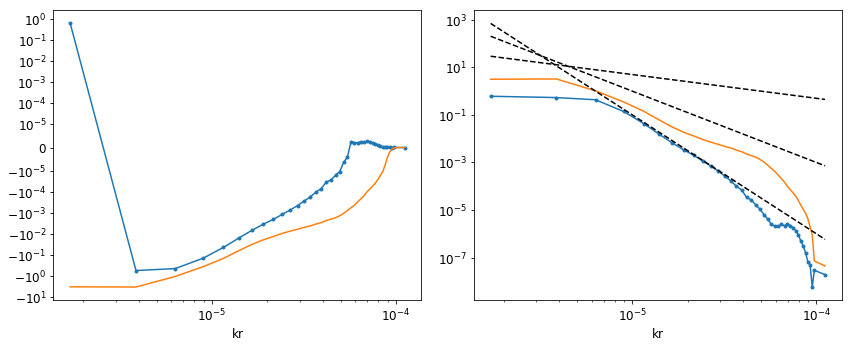

In [139]:
plt.figure(figsize=(12,5))

plt.subplot(121)
VTps_region_k.mean('time').plot(Marker='.')
VCps_region_k.mean('time').plot()
plt.xscale('log')
plt.yscale('symlog', linthreshy=1e-5)

plt.subplot(122)
np.abs(VTps_region_k.mean('time')).plot(Marker='.')
np.abs(VCps_region_k.mean('time')).plot()

plt.plot(Tps_region_k.kr, 1e-15*Tps_region_k.kr**-3, linestyle='--', color='k', label='-3')
plt.plot(Tps_region_k.kr, 0.5e-4*Tps_region_k.kr**-1, linestyle='--', color='k', label='-1')
plt.plot(Tps_region_k.kr, 1e-26*Tps_region_k.kr**-5, linestyle='--', color='k', label='-5')

plt.xscale('log')
plt.yscale('log')

plt.tight_layout()

Omega-K Spectra

In [141]:
Tps_region_kw  = xrft.power_spectrum(Tregion, dim=['XC','YC','time'], window='hanning').rename('T_spec').load()
Cps_region_kw  = xrft.power_spectrum(Cregion, dim=['XC','YC','time'], window='hanning').rename('C_spec').load()
Vps_region_kw  = xrft.power_spectrum(Vregion, dim=['XC','YC','time'], window='hanning').rename('V_spec').load()
Ups_region_kw  = xrft.power_spectrum(Uregion, dim=['XC','YC','time'], window='hanning').rename('U_spec').load()

In [144]:
Tps_region_kw

<xarray.DataArray 'T_spec' (freq_time: 1980, freq_YC: 160, freq_XC: 160)>
array([[[ 915.99968801,  188.78519697,  770.57275032, ...,
         1075.65765961,  770.57275032,  188.78519697],
        [ 883.00061134,  696.89304084,  557.68176412, ...,
          403.23069978,  767.46202853,  182.89897762],
        [ 600.84087203,  333.61007018,  558.09790731, ...,
          305.30310486,  324.91753352,   27.55941886],
        ...,
        [2425.21817669,  767.34369521,  362.89045208, ...,
         1648.82254134, 1326.0358501 , 1347.97243049],
        [ 600.84087203,   27.55941886,  324.91753352, ...,
         1425.29657278,  558.09790731,  333.61007018],
        [ 883.00061134,  182.89897762,  767.46202853, ...,
         1996.61865095,  557.68176412,  696.89304084]],

       [[ 977.55173217,  898.79849768,  225.48674262, ...,
          535.06698121,  995.17961043,   70.57105912],
        [ 137.12747038, 1012.54623336,  245.5165048 , ...,
          728.19879971, 1321.89957498,  941.41107417],

In [153]:
def iso_spec(ds):
    
    #Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    omegalen = len(ds.freq_time)
    
    nfactor = 4. 
    ds_iso = np.zeros([omegalen ,  int(klen/nfactor+1)])

    for j in range(0,omegalen):
        
            kr, ds_iso[j,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(freq_time=j), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'freq_time':ds.freq_time.values, 'kr':kr }, 
                             dims=['freq_time','kr'])
    
    return ds_iso_xr

In [154]:
Tps_region_kw_iso = iso_spec(Tps_region_kw)
Cps_region_kw_iso = iso_spec(Cps_region_kw)
Ups_region_kw_iso = iso_spec(Ups_region_kw)
Vps_region_kw_iso = iso_spec(Vps_region_kw)

/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/.conda/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [165]:
from matplotlib.colors import LogNorm

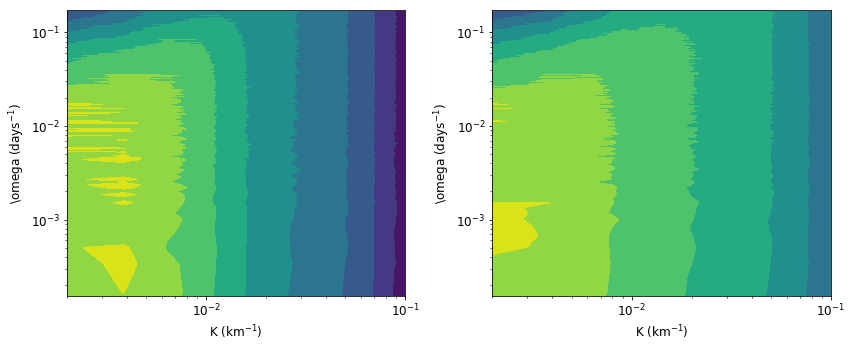

In [213]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(Tps_region_kw_iso.kr*1e3, Tps_region_kw_iso.freq_time*24*3600, 
             Tps_region_kw_iso, norm= LogNorm(),levels=31)
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e-3, 1e-1])
plt.ylim([1/18/360, 2e-6*24*3600])
plt.xlabel(r'K (km$^{-1}$)')
plt.ylabel(r'\omega (days$^{-1}$)')

plt.subplot(122)
plt.contourf(Tps_region_kw_iso.kr*1e3, Tps_region_kw_iso.freq_time*24*3600, 
             Cps_region_kw_iso, norm= LogNorm(), levels=31)
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e-3, 1e-1])
plt.ylim([1/18/360, 2e-6*24*3600])
plt.xlabel(r'K (km$^{-1}$)')
plt.ylabel(r'\omega (days$^{-1}$)')

plt.tight_layout()

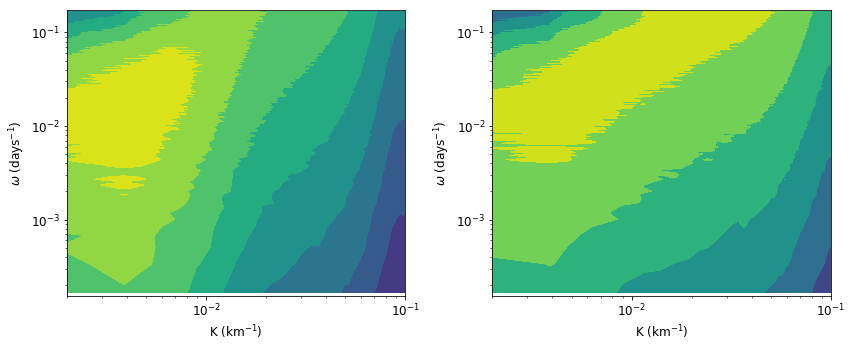

In [217]:
plt.figure(figsize=(12,5))

plt.subplot(121)
plt.contourf(Tps_region_kw_iso.kr*1e3, Tps_region_kw_iso.freq_time*24*3600, 
             Tps_region_kw_iso*Tps_region_kw_iso.kr*Tps_region_kw_iso.freq_time,
             norm= LogNorm(),levels=31)
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e-3, 1e-1])
plt.ylim([1/18/360, 2e-6*24*3600])
plt.xlabel(r'K (km$^{-1}$)')
plt.ylabel(r'$\omega$ (days$^{-1}$)')

plt.subplot(122)
plt.contourf(Tps_region_kw_iso.kr*1e3, Tps_region_kw_iso.freq_time*24*3600, 
             Cps_region_kw_iso*Tps_region_kw_iso.kr*Tps_region_kw_iso.freq_time,
             norm= LogNorm(), levels=31)
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e-3, 1e-1])
plt.ylim([1/18/360, 2e-6*24*3600])
plt.xlabel(r'K (km$^{-1}$)')
plt.ylabel(r'$\omega$ (days$^{-1}$)')

plt.tight_layout()

(1e-06, 0.17)

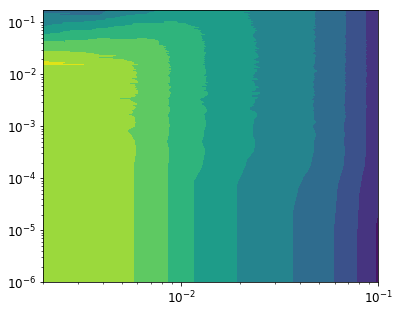

In [183]:
plt.figure(figsize=(6,5))

plt.contourf(Tps_region_kw_iso.kr*1e3, Tps_region_kw_iso.freq_time*24*3600, 
             Ups_region_kw_iso+Vps_region_kw_iso, norm= LogNorm(), levels=31)
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e-3, 1e-1])
plt.ylim([1e-6, 1.7e-1])

In [186]:
Ups_region_kw_iso

<xarray.DataArray (freq_time: 1980, kr: 41)>
array([[         nan,  79.05310943, 100.88345959, ...,   1.13576651,
          0.99667755,   0.41983427],
       [         nan,  69.75358147, 140.35112478, ...,   1.15421837,
          0.96039776,   0.4162159 ],
       [         nan,  32.10188062, 184.57509255, ...,   1.17298881,
          0.99429923,   0.41705499],
       ...,
       [         nan,  28.97267824, 120.58556321, ...,   1.1111164 ,
          0.98302419,   0.3942537 ],
       [         nan,  32.10188062, 184.57509255, ...,   1.17298881,
          0.99429923,   0.41705499],
       [         nan,  69.75358147, 140.35112478, ...,   1.15421837,
          0.96039776,   0.4162159 ]])
Coordinates:
  * freq_time  (freq_time) float64 -1.929e-06 -1.927e-06 ... 1.925e-06 1.927e-06
  * kr         (kr) float64 0.0 1.698e-06 3.866e-06 ... 9.743e-05 0.0001114

In [187]:
(Ups_region_kw_iso+Vps_region_kw_iso)*Tps_region_kw_iso.freq_time*Tps_region_kw_iso.kr

<xarray.DataArray (freq_time: 1980, kr: 41)>
array([[            nan, -5.46928122e-10, -1.57661230e-09, ...,
        -5.61792241e-10, -5.04261036e-10, -2.15902422e-10],
       [            nan, -2.93515757e-10, -1.71214654e-09, ...,
        -5.40036389e-10, -5.30065260e-10, -2.14128896e-10],
       [            nan, -1.87900224e-10, -2.25878976e-09, ...,
        -6.07416684e-10, -5.34140778e-10, -2.20396559e-10],
       ...,
       [            nan,  2.18291260e-10,  1.95504762e-09, ...,
         6.12770094e-10,  4.93815487e-10,  2.14321608e-10],
       [            nan,  1.87900224e-10,  2.25878976e-09, ...,
         6.07416684e-10,  5.34140778e-10,  2.20396559e-10],
       [            nan,  2.93515757e-10,  1.71214654e-09, ...,
         5.40036389e-10,  5.30065260e-10,  2.14128896e-10]])
Coordinates:
  * freq_time  (freq_time) float64 -1.929e-06 -1.927e-06 ... 1.925e-06 1.927e-06
  * kr         (kr) float64 0.0 1.698e-06 3.866e-06 ... 9.743e-05 0.0001114

(1e-06, 0.17)

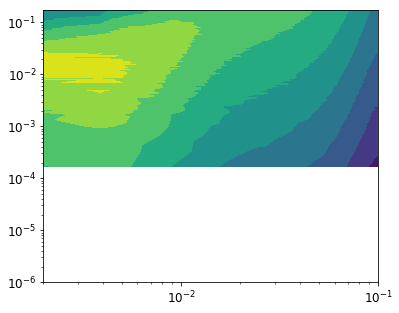

In [196]:
plt.figure(figsize=(6,5))

plt.contourf(Tps_region_kw_iso.kr*1e3, Tps_region_kw_iso.freq_time*24*3600, 
            (Ups_region_kw_iso+Vps_region_kw_iso)*Tps_region_kw_iso.freq_time*Tps_region_kw_iso.kr, 
             levels=31, norm= LogNorm())
plt.xscale('log')
plt.yscale('log')
plt.xlim([2e-3, 1e-1])
plt.ylim([1e-6, 1.7e-1])

In [166]:
Tps_region_kw_iso.plot.contourf()
plt.xscale('log')
plt.yscale('log')
plt.xlim([5e-7, 1e-4])
plt.ylim([1e-12, 5e-6])

TypeError: object of type 'int' has no len()